In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates import Distance
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

In [2]:
# --- Load Spitzer image (Galactic WCS) ---
with fits.open("GLM_02850_0000_mosaic_I1.fits") as hdul:
    wcs  = WCS(hdul[0].header)
    data = hdul[0].data    

# --- Load Gaia (ICRS) and convert to Galactic ---
tab = Table.read("Cone_GaiaDR3.fits", hdu=1)
ra  = np.array(tab["ra"], float)
dec = np.array(tab["dec"], float)
good = np.isfinite(ra) & np.isfinite(dec)
c_icrs = SkyCoord(ra[good]*u.deg, dec[good]*u.deg, frame="icrs")
c_gal  = c_icrs.galactic
l = c_gal.l.deg
b = c_gal.b.deg

# load apogee and convert
tab_a = Table.read("g28-37-ApogeeNet.fits", hdu=1)
ra_a  = np.array(tab_a["ra"], float)
dec_a = np.array(tab_a["dec"], float)
good_a = np.isfinite(ra_a) & np.isfinite(dec_a)
c_icrs_a = SkyCoord(ra_a[good_a]*u.deg, dec_a[good_a]*u.deg, frame="icrs")
c_gal_a  = c_icrs_a.galactic
l_a = c_gal_a.l.deg
b_a = c_gal_a.b.deg

In [3]:
# pull parallax columns (mas)
plx     = np.array(tab["parallax"], float)[good]
plx_err = np.array(tab["parallax_error"], float)[good]

# 2) Build your parallax band (and optional S/N) on the sliced arrays:
finite = np.isfinite(plx) & np.isfinite(plx_err)
band   = (plx > 0.15) & (plx < 0.25)        # 0.15–0.25 mas ≈ 6.7–4.0 kpc
# sn_mask = (plx_err > 0) & ((plx / plx_err) >= 5)   # S/N ≥ 5
# plx_mask = finite & band & sn_mask


plx_mask = finite & band

In [ ]:
# plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

vmin, vmax = ZScaleInterval().get_limits(data)
im = ax.imshow(data, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)

# lock limits so scatter won't autoscale
# xlim, ylim = ax.get_xlim(), ax.get_ylim()
# ax.autoscale(False)

# gaia scatter
sc = ax.scatter(l, b,
                transform=ax.get_transform("galactic"),
                s=0.6, color='gray', lw=0.4,
                zorder=0.5, clip_on=True, label= f"Gaia DR3 #{len(l)}")
# sc.set_clip_path(ax.patch)
# ax.set_xlim(xlim); ax.set_ylim(ylim)

# apogee scatter
sc = ax.scatter(l_a, b_a,
                transform=ax.get_transform("galactic"),
                s=10, color="red", lw=0.4,
                zorder=0.5, clip_on=True, label= f"Apogee #{len(l_a)}")

# gaia scatter with parallax mask
sc = ax.scatter(l[plx_mask], b[plx_mask],
                transform=ax.get_transform("galactic"),
                s=3, facecolors="lime", edgecolors="none", lw=0.4,
                zorder=3, clip_on=True, label= f"Gaia DR3 (0.15 < plx < 0.25 mas) #{len(l[plx_mask])}")

# centers: header (CRVAL) and data center
crval = wcs.wcs.crval  # native WCS coords (ℓ,b here)
ny, nx = data.shape
cx, cy = nx/2.0, ny/2.0
center_world = wcs.pixel_to_world(cx, cy).galactic
ax.scatter([crval[0]], [crval[1]], transform=ax.get_transform("world"),
           s=200, marker="+", color="yellow", lw=1.2, zorder=4, label="Spitzer center (3.6 microns)")

# on existing axes 'ax' with Galactic WCS:
c = SkyCoord("18h42m51s", "-04d02m54s", frame="icrs")
# print(c.galactic)
c_l=28.3507558
c_b=0.06113212
ax.scatter(c_l, c_b,
           transform=ax.get_transform("galactic"),
           s=200, marker="x", color="orange", lw=1.6, zorder=5, label="G28 center")
ax.legend(loc="upper right", frameon=True, framealpha=0.25)

# labels/grid
ax.set_xlabel("Galactic ℓ (deg)"); ax.set_ylabel("Galactic b (deg)")
ax.coords.grid(color="white", ls="--", alpha=0.3)

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0),
          frameon=True, framealpha=0.25)
plt.savefig('g28_GaiaOverlay.png', bbox_inches='tight')
plt.tight_layout(); plt.show()

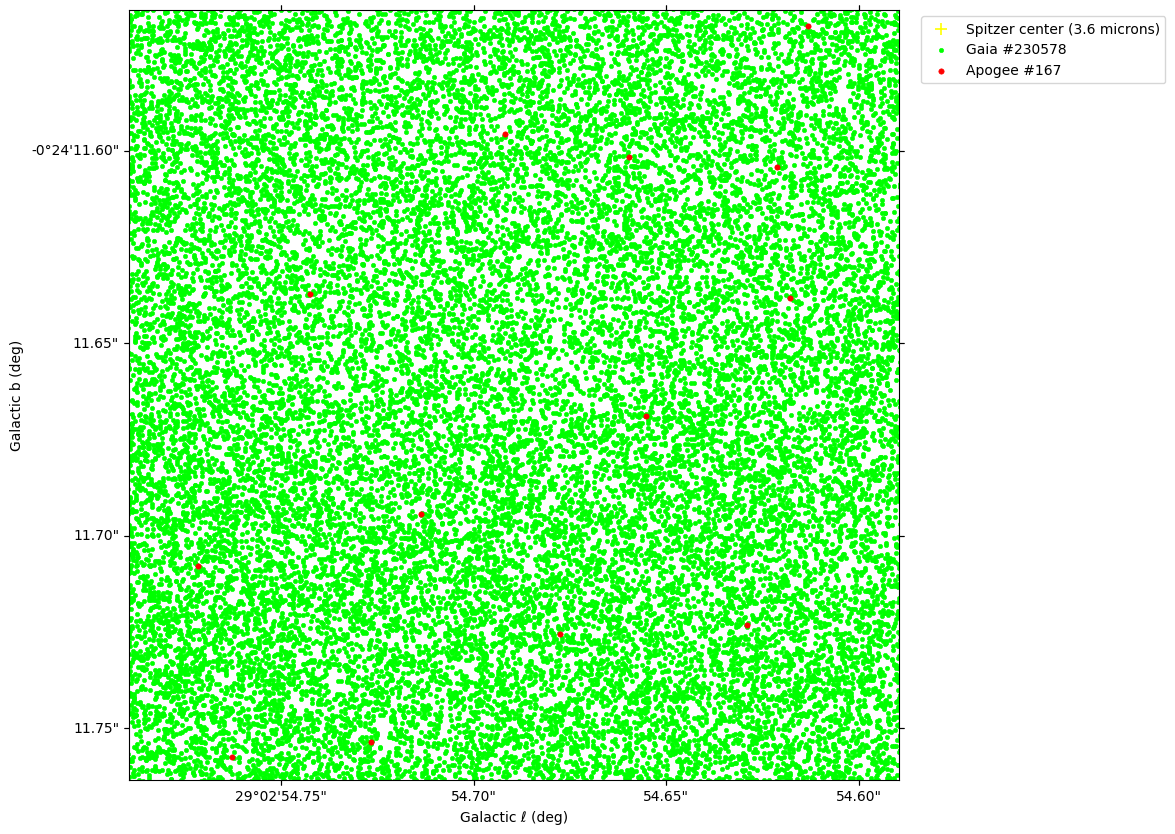

In [17]:
# half-size in degrees
delta = 10.0 / 60.0   # 1 arcmin in deg

# plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

vmin, vmax = ZScaleInterval().get_limits(data)
im = ax.imshow(data, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)

# centers: header (CRVAL) and data center
crval = wcs.wcs.crval  # native WCS coords (ℓ,b here)
ny, nx = data.shape
cx, cy = nx/2.0, ny/2.0
center_world = wcs.pixel_to_world(cx, cy).galactic
ax.scatter([crval[0]], [crval[1]], transform=ax.get_transform("world"),
           s=70, marker="+", color="yellow", lw=1.2, zorder=4, label="Spitzer center (3.6 microns)")


# gaia scatter
sc = ax.scatter(l, b,
                s=10, color="lime", lw=0.4,
                zorder=0.5, clip_on=True, label= f"Gaia #{len(l)}")

# apogee scatter
sc = ax.scatter(l_a, b_a,
                s=15, color="red", lw=0.4,
                zorder=0.5, clip_on=True, label= f"Apogee #{len(l_a)}")


ax.set_xlim(c_l - delta, c_l + delta)
ax.set_ylim(c_b - delta, c_b + delta)

# labels/grid
ax.set_xlabel("Galactic ℓ (deg)"); ax.set_ylabel("Galactic b (deg)")
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.show()
